# 밑바닥부터 시작하는 딥러닝

# Deep Learning from Scratch

# 6 학습 관련 기술들

가중치 매개변수의 최적값을 탐색하는 최적화 방법. 가중치 매개변수 초기값, 하이퍼파라미터 설정 방법

오버피팅 대응책인 가중치 감소, 드롭아웃

배치 정규화

## 6.1 매개변수 갱신

최적화 : 손실 함수의 값을 가능한 낮추는 매개변수를 찾음. 최적 매개변수를 찾는 문제를 푸는 것.

확률적 경사 하강법(SGD) : 매개변수 기울기를 구해 기울어진 방향으로 매개변수 값을 갱신하여 점점 최적의 매개변수로 다가가는 방법

### 6.1.1 모험가 이야기

SGD의 전략: 지금 서있는 장소에서 가장 크게 기울어진 방향으로 가는 것.

### 6.1.2 확률적 경사 하강법(SGD)

#### 식 6.1 SGD
\begin{equation*}
W \leftarrow W - \eta \frac{\partial L}{\partial W}
\end{equation*}

\begin{equation*}
W : 갱신할 매개변수
\end{equation*}
\begin{equation*}
\frac{\partial L}{\partial W} : 손실 함수의 기울기
\end{equation*}
\begin{equation*}
\eta : 학습률, 미리 정해서 사용, 0.01 or 0.001 등
\end{equation*}

<- 우변의 값으로 좌변의 값을 갱신

SGD 파이썬 클래스 구현

In [47]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

lr : 학습률, learning rate. 인스턴스 변수로 유지

update(params, grads) : SGD 과정에서 반복해서 호출됨

params : 딕셔너리 변수. 가중치 매개변수 저장됨. 예시 params['W1']

grads : 딕셔너리 변수. 기울기가 저장됨. 예시 grads['W1']

신경망 매개변수 진행 의사코드

```python
network = TwoLayerNet(...)
optimizer = SGD() ###
for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...) # 미니배치
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads) ###
    ...
```

optimizer : 변수. 뜻은 최적화를 행하는 자

매개변수 갱신은 optimizer가 책임지고 수행. optimizer에 매개변수와 기울기 정보만 넘기면 됨

최적화를 담당하는 클래스를 분리 구현하면 기능을 모듈화하기 좋음

모멘텀 최적화 기법 역시 update(params, grads)라는 공통의 메서드를 갖도록 구현

optimizer = SGD() 문장을 optimizer = Momentum()으로만 변경하면 됨

Lasagne 딥러닝 프레임워크는 최적화 기법을 다음 함수들로 정리함

https://github.com/Lasagne/Lasagne/blob/master/lasagne/updates.py

### 6.1.3 SGD의 단점

#### 식 6.2 SGD

다음 함수의 최솟값을 구하는 문제 예시

\begin{equation*}
f(x,y) = \frac{1}{20} x^2 + y^2
\end{equation*}

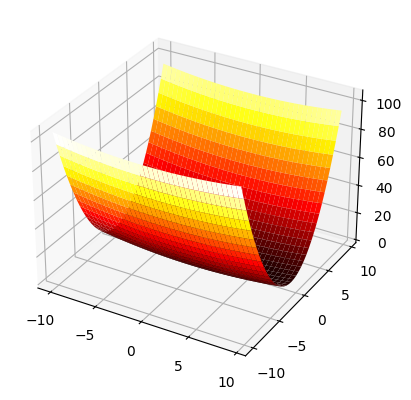

In [48]:
# 그림 6-1 f(x, y) = (1/20) * x**2 + y**2 그래프
# 3차원 참고주소: https://www.datascienceschool.net/view-notebook/6e71dbff254542d9b0a054a7c98b34ec/
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
X = np.arange(-10, 10, 0.5)
Y = np.arange(-10, 10, 0.5)
XX, YY = np.meshgrid(X, Y)
ZZ = (1 / 20) * XX**2 + YY**2

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, cmap='hot');

(-10.0, 10.0)

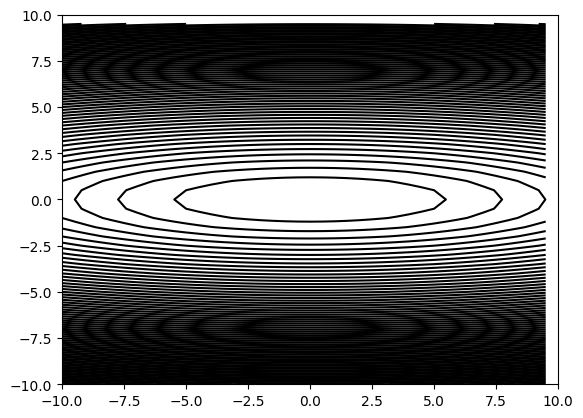

In [49]:
# 그림 6-1 f(x, y) = (1/20) * x**2 + y**2 등고선
plt.contour(XX, YY, ZZ, 100, colors='k')
plt.ylim(-10, 10)
plt.xlim(-10, 10)

In [50]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성

    for idx in range(x.size):
        tmp_val = x[idx]

        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)

        # f(x-h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원

    return grad

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


f(x,y) = 1/20*x**2 + y**2 의 기울기


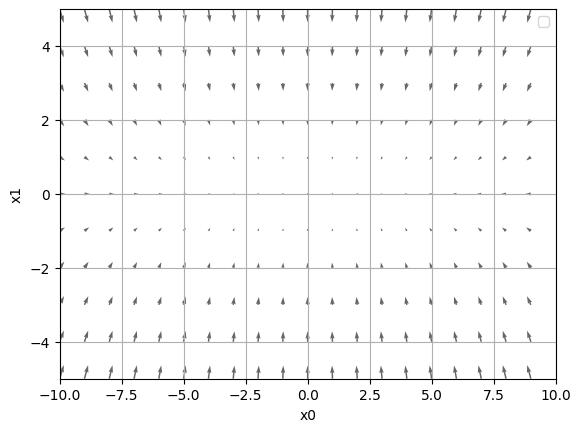

In [51]:
# 그림 6-2 f(x, y) = (1/20) * x**2 + y**2 의 기울기
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch04/gradient_2d.py 소스 참고
from mpl_toolkits.mplot3d import Axes3D

def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)

        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)

        return grad

def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)

x0 = np.arange(-10, 10, 1)
x1 = np.arange(-10, 10, 1)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([(1/(20**0.5))*X, Y]) )


print('f(x,y) = 1/20*x**2 + y**2 의 기울기')
plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
plt.xlim([-10, 10])
plt.ylim([-5, 5])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.legend()
plt.draw()
plt.show()

위 함수의 기울기는 아래와 같음. 이 기울기는 y축 방향은 크고 x축 방향은 작다는 것이 특징임

y축 방향은 가파른데 x축 방향은 완만함

식에서는 최소값이 되는 장소는 0,0 이지만 그림에서 보여주는 기울기 대부분은 0,0을 가리키지 않는다

6-1의 함수에 SGD 적용, 초기값은 (-7.0, 2.0)

![](./img/02.png)

SGD 단점 : 비등방성(anisotropy) 함수(방향에 따라 기울기가 달라지는 함수)에서 <u>탐색경로가 비효율적.</u>

SGD의 단점을 개선해주는 모멘텀, AdaGrad,Adam을 학습

### 6.1.4 모멘텀

모멘텀: Momentum, 운동량

#### 식 6.3
\begin{equation*}
v \leftarrow \alpha v - \eta \frac{\partial{L}}{\partial{W}}
\end{equation*}

#### 식 6.4
\begin{equation*}
W \leftarrow W + v
\end{equation*}

\begin{equation*}
W : 갱신할 매개변수
\end{equation*}
\begin{equation*}
\frac{\partial L}{\partial W} : 손실 함수의 기울기
\end{equation*}
\begin{equation*}
\eta : 학습률, 미리 정해서 사용
\end{equation*}

v : 물리에서 말하는 속도(velocity)

alpha v(알파 * v) : 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할

식 6.3 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙을 나타냄

식 6.4 : 모멘텀에 따라 공이 그릇의 바닥을 구르는 듯한 움직임을 보임

모멘텀의 구현

In [52]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

v: 물체의 속도

v는 초기화 때는 아무것도 담지 않고, update가 처음 호출될 때 같은 구조의 데이터를 딕셔너리 변수로 저장

![](./img/03.png)

모멘텀의 갱신 경로는 공이 그릇 바닥을 구르듯 움직임. SGD와 비교하면 지그재그 정도가 덜함

### 6.1.5 AdaGrad

학습률이 작으면 학습시간이 너무 길어지고 반대로 너무 크면 발산하여 학습이 제대로 안됨

학습률 감소(learning rate decay) : 학습을 진행하면서 학습률을 점차 줄여가는 방법

개별 매개변수에 적응적으로(adative) 학습률을 조정하면서 학습을 진행

#### 식 6.5
\begin{equation*}
h := h + \frac{\partial{L}}{\partial{W}} \odot \frac{\partial{L}}{\partial{W}}
\end{equation*}
\begin{equation*}
\odot : 행렬의 원소별 곱
\end{equation*}

#### 식 6.6
\begin{equation*}
W := W - \eta \frac{1}{\sqrt{h}} \frac{\partial{L}}{\partial{W}}
\end{equation*}

\begin{equation*}
W : 갱신할 매개변수
\end{equation*}
\begin{equation*}
\frac{\partial L}{\partial W} : 손실 함수의 기울기
\end{equation*}
\begin{equation*}
\eta : 학습률, 미리 정해서 사용
\end{equation*}

h : 기존 기울기 값을 제곱하여 계속 더해줌

매개변수를 갱신할 때 1/sqrt(h)을 곱해 학습률을 조정

매개변수의 원소 중에서 많이 움직인(크게 갱신된) 원소는 학습률이 낮아진다는 뜻. 학슴률의 감소가 매개변수의 원소마다 다르게 적용됨을 뜻

AdaGrad는 학습을 진행할 수록 갱신 강도가 약해짐.

실제로 무한히 계속 학습한다면 어느 순간 갱신량이 0이 되어 전혀 갱신되지 않게 됨

이 문제를 개선하기 위한 기법으로 RMSProp이 있음

**RMSProp **

지수이동평균(Exponential Moving Average, EMA)를 이용하여 먼 과거의 기울기를 서서히 잊고 새로운 기울기 정보를 크게 반영. 과거 기울기의 반영규모를 기하급수적으로 감소시킴

AdaGrad의 구현

In [53]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

마지막 줄에서 1e-7이라는 작은 값을 더하는 부분이 0으로 나누는 사태를 막음

대부분의 딥러닝 프레임워크에서 이 값도 인수로 설정 가능

처음에는 크게 움직이지만 갱신 정도가 작아지도록 조정됨

![](./img/04.png)

최솟값을 향해 효율적으로 움직임. y축 방향은 기울기가 커서 처음에는 크게 움직이지만, 그 큰 움직임에 비례해 갱신정도도 큰 폭으로 작아지도록 조정됨. y축 방향으로 갱신강도가 빠르게 약해지고 지그재그 움직임이 줄어듬

### 6.1.6 Adam

모멘텀: 공이 그릇을 구르는 듯한 물리 법칙에 따르는 움직임

AdaGrad: 매개변수의 원소마다 적응적으로 갱신 정도를 조정

Adam: 모멘텀과 Adagrad 기법을 융합

매개변수 공간을 효율적으로 탐색. 하이터파라미터의 '편향 보정'이 진행됨

![](./img/05.png)

momentum때보다 공의 좌우 흔들림이 작다. 학습의 갱신강도를 적응적으로 조정해서 얻는 혜택

Adam의 구현

In [54]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/common/optimizer.py 참고
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

### 6.1.7 어느 갱신 방법을 이용할 것인가?

네 기법의 결과를 비교

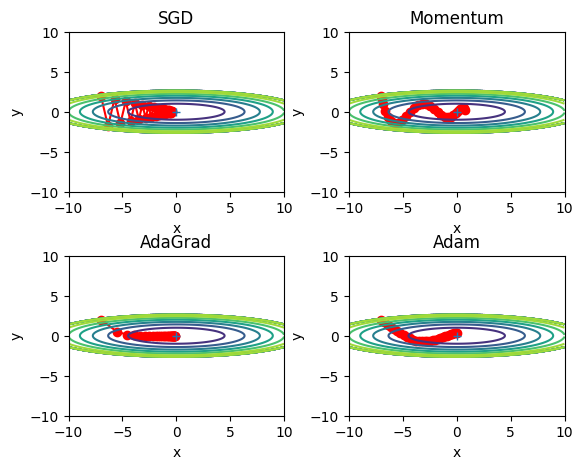

In [65]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/optimizer_compare_naive.py 참고
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)


    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0

    # 그래프 그리기
    plt.subplot(2, 2, idx)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.3, hspace=0.4)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.show()

문제가 무엇이냐에 따라 사용할 기법이 달라짐

하이퍼 파라미터를 어떻게 설정하느냐에 따라서 결과도 바뀜

모든 문제에서 항상 뛰어난 기법은 아직 없음

이 책에서는 SGD, Adam을 많이 사용.

===========iteration:0===========
SGD:2.267181119507956
Momentum:2.43608308297938
AdaGrad:2.098304794704574
Adam:2.1627118063274846
===========iteration:100===========
SGD:1.5350619785021022
Momentum:0.33146970644921486
AdaGrad:0.15130965983258465
Adam:0.2170223085157133
===========iteration:200===========
SGD:0.8467883034754445
Momentum:0.30773802236554776
AdaGrad:0.14664856035330548
Adam:0.19508487235127572
===========iteration:300===========
SGD:0.5768993524457575
Momentum:0.23138295176097454
AdaGrad:0.06571214995118943
Adam:0.13296344146731176
===========iteration:400===========
SGD:0.35601381356183404
Momentum:0.18453254738908326
AdaGrad:0.06874649584565483
Adam:0.10368874553632068
===========iteration:500===========
SGD:0.5193304820912097
Momentum:0.28745617502355947
AdaGrad:0.11656302655149572
Adam:0.16434786870383072
===========iteration:600===========
SGD:0.2766809962849097
Momentum:0.0668590087537018
AdaGrad:0.026917357846646256
Adam:0.08680431021319619
===========iteration:7

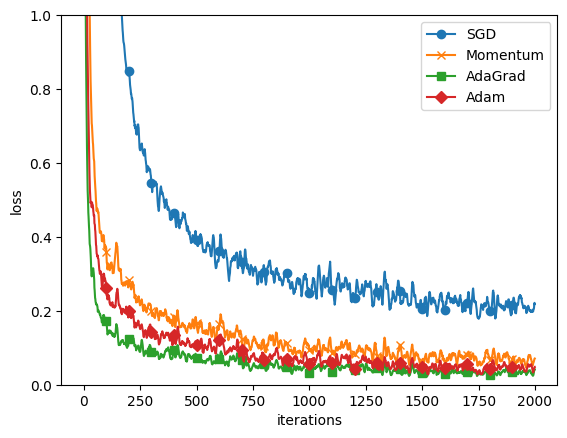

In [67]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/optimizer_compare_mnist.py 참고
# coding: utf-8
#import os
#import sys
#sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
#from common.optimizer import *

# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []

# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

각 층이 100개의 뉴런으로 구성된 5층 신경망에서 ReLU를 활성화 함수로 사용해 측정

하이퍼파라미터인 학습률과 신경망의 구조(층 깊이 등)에 따라 결과가 달라짐

일반적으로 SGD보다 다른 세 기법이 빠르게 학습하고, 때로는 최종 정확도도 높음

## 6.2 가중치의 초기값

가중치의 초기값을 무엇으로 설정하느냐가 신경망 학습의 성패를 가름

### 6.2.1 초기값을 0으로 하면?

가중치 감소(weight decay) : 오버피팅을 억제해 범용 성능을 높이는 테크닉

* 가중치 매개변수 값이 작아지도록 학습하는 방법.
* 가중치 값을 작게 하여 오버피팅이 일어나지 않음.

초기값을 작게 하기 위해 0.01 * np.random.randn(10,100) 처럼 정규분포로 생성된 값에 0.01을 곱함

초기값을 모두 0으로 해서는 안되는 이유?

오차역전법에서 모든 가중치의 값이 똑같이 갱신되기 때문

* 순전파: 입력파의 가중치가 0이기 때문에 두 번째 층의 뉴런에 모두 같은 값이 전달
* 역전파: 가중치가 모두 똑같이 갱신

가중치를 여러개 갖는 의미를 사라지게 함.
가중치가 고르게 되어버리는 상황을 막으려면 초깃값을 무작위로 설정해야 함

### 6.2.2 은닉층의 활성화값 분포

가중치의 초기값에 따라 은닉층 활성화 값들이 어떻게 변화는지 실험

각 층의 활성화값 분포를 히스토그램으로 그림

In [69]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/weight_init_activation_histogram.py 참고
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

def get_activation(hidden_layer_size, x, w, a_func=sigmoid):
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        a = np.dot(x, w)

        # 활성화 함수도 바꿔가며 실험해보자！
        z = a_func(a)
        # z = ReLU(a)
        # z = tanh(a)

        activations[i] = z
    return activations

# 초깃값을 다양하게 바꿔가며 실험해보자！
w = np.random.randn(node_num, node_num) * 1
# w = np.random.randn(node_num, node_num) * 0.01
# w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
# w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

z = sigmoid
# z = ReLU
# z = tanh

activations = get_activation(hidden_layer_size, x, w, z)

표준편차가 1인 정규분포의 활성화값들의 분포

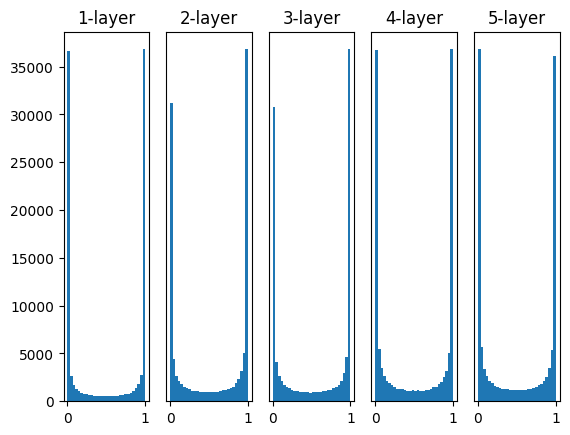

In [70]:
# 히스토그램 그리기
def get_histogram(activations):
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        # plt.xlim(0.1, 1)
        # plt.ylim(0, 7000)
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()

get_histogram(activations)

기울기 소실(gradient vanishing)

데이터가 0과 1에 치우쳐 분포하게 되면 역전파 기울기 값이 점점 작아지다 사라짐

가중치의 표준편차를 0.01로 변경


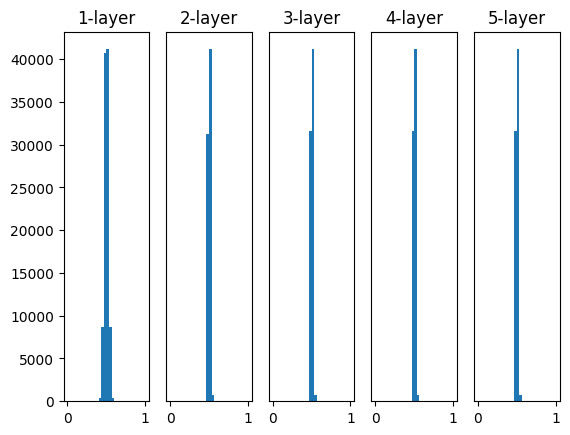

In [71]:
w = np.random.randn(node_num, node_num) * 0.01
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

0.5 부근에 집중. 활성화값들이 치우쳤다는 것은 표현력 관점에서 큰 문제

표현력을 제한: 예를 들어 뉴런 100개가 거의 같은 값을 출력한다면 뉴런 1개짜리와 별반 다를게 없음

<u>Xavier 초기값</u>

앞 계층의 노드가 n개라면 표준편차가 1 / np.sqrt(n)인 정규분포를 사용

사비에르 논문은 앞 층의 노드 수 외에 다음 출력 노드 수도 고려한 설정 값 제안.

카페 등의 프레임워크는 앞층의 입력 노드만으로 계산하도록 단순화.

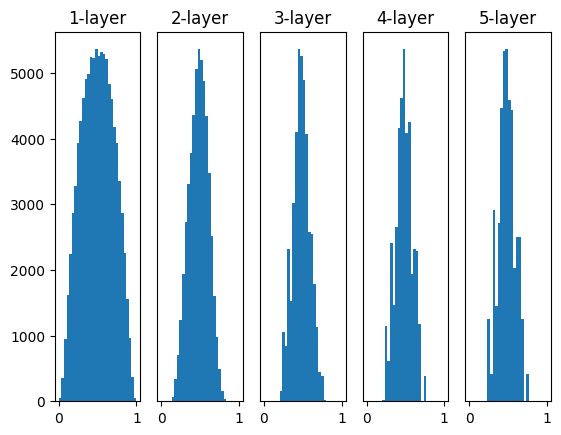

In [72]:
# Xavier 초기값
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

In [73]:
층이 깊어지면서 형태가 다소 일그러지지만, 넓게 분포됨

시그모이드 함수의 표현력도 제한받지 않고 학습이 효율적으로 이뤄질 것

SyntaxError: invalid syntax (346857021.py, line 1)